## Scroll down and check your arguments before running

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd '/content/drive/My Drive/Text-Based Anomaly Detection/github/'
%cd '/content/drive/My Drive/Github copy for modifications/'
!pwd

# !pip install tensorboardX
# !pip install transformers

/content/drive/.shortcut-targets-by-id/1hufUcQIV0xjJXJyMqP-CvP4ef014Q273/Github copy for modifications
/content/drive/.shortcut-targets-by-id/1hufUcQIV0xjJXJyMqP-CvP4ef014Q273/Github copy for modifications


In [2]:
import os
import json
import time
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import cpu_count
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader
from collections import OrderedDict, defaultdict
from ptb import PTB
from utils import to_var, expierment_name
from model import SentenceVAE
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [14]:
def main(args):
    ts = time.strftime('%Y-%b-%d-%H:%M:%S', time.gmtime())
    t1 = time.time() #starting time

    splits = ['train', 'valid'] + (['test'] if args.test else [])

    datasets = OrderedDict()


    for split in splits:
        datasets[split] = PTB(
            data_dir=args.data_dir,
            split=split,
            create_data=args.create_data,
            max_sequence_length=args.max_sequence_length
        )
    
    model = SentenceVAE(
        vocab_size=datasets['train'].vocab_size,
        sos_idx=datasets['train'].sos_idx,
        eos_idx=datasets['train'].eos_idx,
        pad_idx=datasets['train'].pad_idx,
        unk_idx=datasets['train'].unk_idx,
        max_sequence_length=args.max_sequence_length,
        embedding_size=args.embedding_size,
        rnn_type=args.rnn_type,
        hidden_size=args.hidden_size,
        word_dropout=args.word_dropout,
        embedding_dropout=args.embedding_dropout,
        latent_size=args.latent_size,
        num_layers=args.num_layers,
        bidirectional=args.bidirectional
    )
    
    model.load_state_dict(torch.load(args.load_checkpoint))
    print("Model loaded from %s" % args.load_checkpoint)

    if torch.cuda.is_available():
        model = model.cuda()


    print(model)

    def kl_anneal_function(anneal_function, step, k, x0):
        if anneal_function == 'logistic':
            return float(1/(1+np.exp(-k*(step-x0))))
        elif anneal_function == 'linear':
            return min(1, step/x0)
        elif anneal_function == '1':
            return k

    NLL_full = torch.nn.NLLLoss(ignore_index=datasets['train'].pad_idx, reduction='none')
    NLL = torch.nn.NLLLoss(ignore_index=datasets['train'].pad_idx, reduction='sum')
    def loss_fn(logp, target, length, mean, logv, anneal_function, step, k, x0):

        # cut-off unnecessary padding from target, and flatten
        target = target[:, :torch.max(length).item()].contiguous().view(-1)
        logp = logp[:, :torch.max(length).item(),:].contiguous().view(-1, logp.size(2))

        # Negative Log Likelihood
        NLL_loss = NLL(logp, target.type(torch.long))

        # KL Divergence
        KL_loss = -0.5 * torch.sum(1 + logv - mean.pow(2) - logv.exp())
        KL_weight = kl_anneal_function(anneal_function, step, k, x0)

        return NLL_loss, KL_loss, KL_weight

    def loss_fn_full(logp, target, length, mean, logv):

        # cut-off unnecessary padding from target, and flatten
        target = target[:, :torch.max(length).item()].contiguous().view(-1)
        logp = logp[:, :torch.max(length).item(),:].contiguous().view(-1, logp.size(2))
        # shape (bs*seq_len*vocab)
        # Negative Log Likelihood
        NLL_loss = NLL_full(logp, target.type(torch.long))
        NLL_loss = NLL_loss.view(-1,torch.max(length).item())

        NLL_loss = torch.sum(NLL_loss,1)/length        

        KL_loss = -0.5 * torch.sum((1 + logv - mean.pow(2) - logv.exp()),1)

        return NLL_loss, KL_loss

    def Normplot(val,test,min=False,max=False,n=False, losstp="NLL-loss pr. word"):
        if n==False:
            n = int(len(val)/15)
        if min==False:
            min = np.min((val,test))
        if max==False:
            max = np.max((val,test))

        plt.figure(figsize=(12,8))
        bins = np.linspace(min,max,n)
        binwidth = (max+min)/n
        binedges = np.linspace(min-binwidth,max+binwidth,n+1)
        histval,edges = np.histogram(val,binedges)
        histtest,edges = np.histogram(test,binedges)

        erval = np.sqrt(histval)
        erval = erval/np.sum(histval)
        histval = histval/np.sum(histval)
        ertest = np.sqrt(histtest)
        ertest = ertest/np.sum(histtest)
        histtest = histtest/np.sum(histtest)


        plt.bar(bins,histval,yerr=erval,label="Validaiton scores",width=(binedges[-1]-binedges[0])/n,alpha=0.5,color="green")
        plt.bar(bins,histtest,yerr=ertest,label="Test scores",width=(binedges[-1]-binedges[0])/n,alpha=0.3,color="red")
        plt.legend(fontsize='x-large')
        plt.title("score",fontsize='x-large')
        plt.xlabel(losstp,fontsize='x-large')
        plt.ylabel("counts(normalized)",fontsize='x-large')
        plt.show()

    def roccurve(val,test,N=50):
        val=np.column_stack((val,np.zeros(len(val))))
        test=np.column_stack((test,np.ones(len(test))))
        total=np.append(val,test,axis=0)
        total=total[total[:,0].argsort()]
        nval=np.shape(val)[0]
        ntot=np.shape(total)[0]
        ntest=ntot-nval
        itest=0
        ival=0
        j=0
        testar=[]
        valar=[]

        for i in range(ntot):

            if total[ntot-i-1,1]==1:
                itest+=1
                if itest/ntest>j/N:
                    j=j+1
                    testar+=[itest]
                    valar+=[ival]
                if itest==ntest:
                    break

            else:
                ival+=1

        testar+=[itest]
        valar+=[ival]

        testar=np.array(testar)/ntest
        valarer=np.sqrt(valar)
        valar=np.array(valar)/nval
        valarer=np.array(valarer)/nval

        # plt.plot(testar,valar,"-")
        plt.errorbar(testar,valar,yerr=valarer)
        plt.xlabel("True positive rate")
        plt.ylabel("False positive rate")
        plt.show()
    
        # print("score:",score,"score2:",sum(valar)*(testar[1]-testar[0]))
        # print("10% true positive gives:",valar[int(N*0.1)], " false positive rate,\n50% true positive gives:",valar[int(N/2)],
        #       " false positive rate,\n 90% true positive gives:", valar[int(N*0.9)], " false positive rate")
        print("10 %% true positive gives: %4.2f +- %2.2f %% false positive rate,\n50 %% true positive gives: %4.2f +- %2.2f %% false positive rate,\n90 %% true positive rate gives: %4.2f +- %2.2f %% false positive rate" % (valar[int(N*0.1)]*100,valarer[int(N*0.1)]*100,valar[int(N*0.5)]*100,valarer[int(N*0.5)]*100,valar[int(N*0.9)]*100,valarer[int(N*0.9)]*100))


    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

    tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor
    #tensor = torch.cuda.FloatTensor if False else torch.Tensor
    step = 0
    
    lossar_train = np.empty((0,5), float)
    lossar_validation = np.zeros((0,5), float)
    lossar_validation_acum = np.zeros((0,7), float)
    lossar_test = np.zeros((0,5), float)
    lossar_test_acum = np.zeros((0,7), float)

    splits=['valid','test']
    
    NLL_full_val = np.zeros((0,1), float)
    NLL_full_test = np.zeros((0,1), float)
    loss_full_val = np.zeros((0,1), float)
    loss_full_test = np.zeros((0,1), float)
    KL_lossfull_val = np.zeros((0,1), float)
    KL_lossfull_test = np.zeros((0,1), float)

    model.eval()

    KL_weight = args.beta

    for split in splits:
        print("\n----- " + split + " --------------")
        
        data_loader = DataLoader(
            dataset=datasets[split],
            batch_size=args.batch_size,
            shuffle=split=='train',
            num_workers=cpu_count(),
            pin_memory=torch.cuda.is_available())
        
        tracker = defaultdict(tensor)
        # Enable/Disable Dropout
        
        if split == 'train':
            model.train()
        else:
            model.eval  
        
        for iteration, batch in enumerate(data_loader):
            batch_size = batch['input'].size(0)
            
            for k, v in batch.items():
                if torch.is_tensor(v):
                    batch[k] = to_var( v)
            
            # Forward pass
            logp, mean, logv, z = model(batch['input'], batch['length' ])
            # loss calculation
            NLL_loss, KL_loss, _ = loss_fn(logp, batch['target'],
                batch['length'], mean, logv, args.anneal_function, step, args.k, args.x0)
            
            loss = (NLL_loss + KL_weight * KL_loss) / batch_size

            if not model.training:
                NLL_lossfull, KL_lossfull = loss_fn_full(logp, batch['target'], batch['length'], mean, logv)
                if args.plt_total_loss == True:
                    lossfull = (NLL_lossfull + KL_weight * KL_lossfull)
            
            if iteration % args.print_every == 0 or iteration+1 == len(data_loader):
                print("%s Batch %04d/%i, Loss %9.4f, NLL-Loss %9.4f, KL-Loss %9.4f, KL-Weight %6.3f, time passed %6.1f"
                      % (split.upper(), iteration, len(data_loader)-1, loss.item(), NLL_loss.item()/batch_size,
                      KL_loss.item()/batch_size, KL_weight, time.time()-t1))
            
            if split == 'valid':
                if 'target_sents' not in tracker:
                    tracker['target_sents'] = list()
                # print("adding to validation")
                NLL_full_val = np.append(NLL_full_val,NLL_lossfull.cpu().detach().numpy())
                if args.plt_total_loss == True:
                    loss_full_val = np.append(loss_full_val,lossfull.cpu().detach().numpy())
                    KL_lossfull_val = np.append(KL_lossfull_val,KL_lossfull.cpu().detach().numpy())
            
            if split == 'test':
                # print("adding to test")
                NLL_full_test = np.append(NLL_full_test,NLL_lossfull.cpu().detach().numpy())
                if args.plt_total_loss == True:
                    loss_full_test = np.append(loss_full_test,lossfull.cpu().detach().numpy())
                    KL_lossfull_test = np.append(KL_lossfull_test,KL_lossfull.cpu().detach().numpy())
                           
    print(NLL_full_val.shape)
    print(NLL_full_test.shape)
    NLL_full_val=NLL_full_val[:len(NLL_full_test)]
    NLL_full_test=NLL_full_test[:len(NLL_full_val)]
    Normplot(NLL_full_val,NLL_full_test)
    roccurve(NLL_full_val,NLL_full_test,N=100)
    
    if args.plt_total_loss == True:
        loss_full_val=loss_full_val[:len(loss_full_test)]
        loss_full_test=loss_full_test[:len(loss_full_val)]
        Normplot(loss_full_val,loss_full_test,losstp="total loss pr. word")
        roccurve(loss_full_val,loss_full_test,N=100)
        KL_lossfull_val=KL_lossfull_val[:len(KL_lossfull_test)]
        KL_lossfull_test=KL_lossfull_test[:len(KL_lossfull_val)]
        Normplot(KL_lossfull_val,KL_lossfull_test,losstp="KL_loss",n=int(len(KL_lossfull_test)/50))
        roccurve(KL_lossfull_val,KL_lossfull_test,N=100)


parser = argparse.ArgumentParser()

parser.add_argument('--data_dir', type=str, default='data')
parser.add_argument('--create_data', action='store_true')
parser.add_argument('--max_sequence_length', type=int, default=30)
parser.add_argument('--min_occ', type=int, default=1) # It's not been used
parser.add_argument('--test', action='store_true')

parser.add_argument('-ep', '--epochs', type=int, default=10)
parser.add_argument('-bs', '--batch_size', type=int, default=32)
parser.add_argument('-lr', '--learning_rate', type=float, default=0.001)

# For BERT pre-trained model hyperparameters check: https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json
parser.add_argument('-vs', '--vocab_size', type=int, default=30522) # Cannot be changed for the moment
parser.add_argument('-eb', '--embedding_size', type=int, default=768) # Cannot be changed for the moment
parser.add_argument('-rnn', '--rnn_type', type=str, default='gru')
parser.add_argument('-hs', '--hidden_size', type=int, default=256)
parser.add_argument('-nl', '--num_layers', type=int, default=1)
#parser.add_argument('-bi', '--bidirectional', action='store_true')
parser.add_argument('-bi', '--bidirectional', type=bool, default=True)
parser.add_argument('-ls', '--latent_size', type=int, default=16)
parser.add_argument('-wd', '--word_dropout', type=float, default=0)
parser.add_argument('-ed', '--embedding_dropout', type=float, default=0.5)

parser.add_argument('-af', '--anneal_function', type=str, default='logistic')
parser.add_argument('-k', '--k', type=float, default=0.0025)
parser.add_argument('-x0', '--x0', type=int, default=4000)
parser.add_argument('-b', '--beta', type=float, default=1)

parser.add_argument('-v', '--print_every', type=int, default=50)
parser.add_argument('-tb', '--tensorboard_logging', action='store_true')
parser.add_argument('-log', '--logdir', type=str, default='logs')
parser.add_argument('-bin', '--save_model_path', type=str, default='bin')
parser.add_argument('-plt_l', '--plt_total_loss', type=bool, default='False')
parser.add_argument('-cp', '--load_checkpoint', type=str, default='bin')

_StoreAction(option_strings=['-cp', '--load_checkpoint'], dest='load_checkpoint', nargs=None, const=None, default='bin', type=<class 'str'>, choices=None, help=None, metavar=None)

## Modify your arguments here:

Model loaded from bin/Saved_models/E10.pytorch
SentenceVAE(
  (embedding_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNor

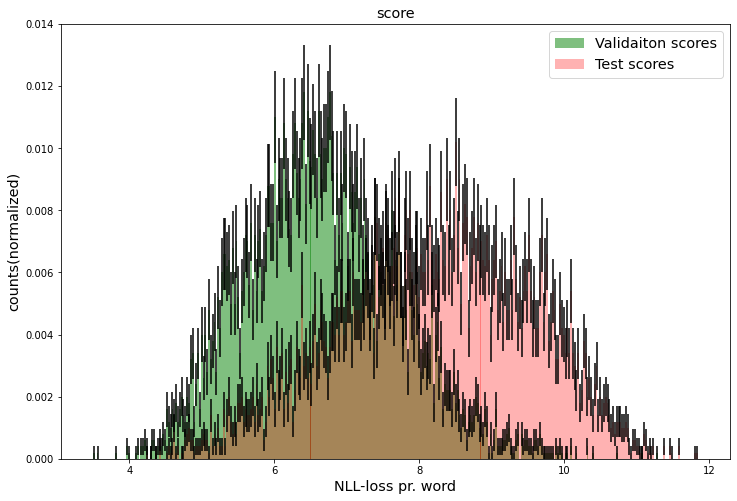

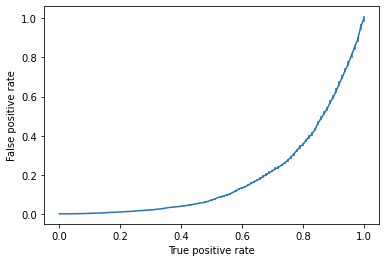

10 % true positive gives: 0.30 +- 0.08 % false positive rate,
50 % true positive gives: 7.16 +- 0.38 % false positive rate,
90 % true positive rate gives: 59.66 +- 1.09 % false positive rate


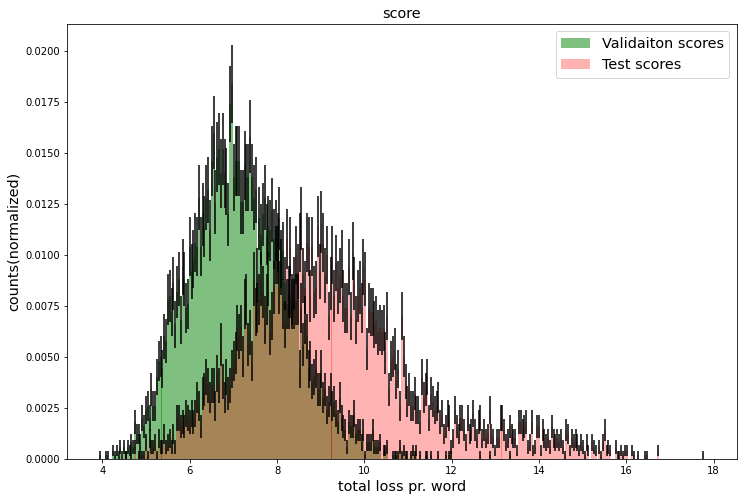

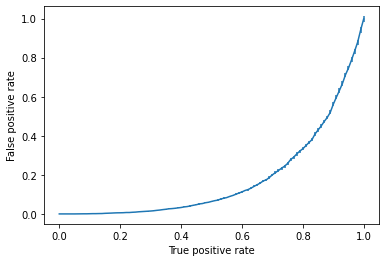

10 % true positive gives: 0.10 +- 0.04 % false positive rate,
50 % true positive gives: 6.38 +- 0.36 % false positive rate,
90 % true positive rate gives: 56.12 +- 1.06 % false positive rate


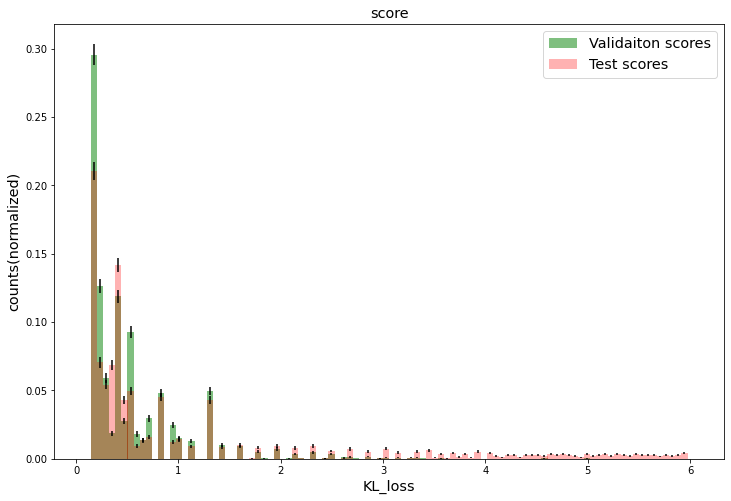

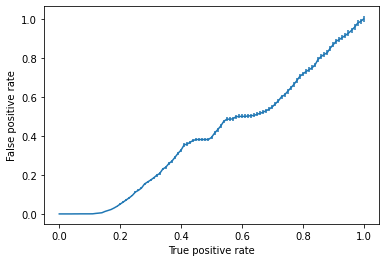

10 % true positive gives: 0.04 +- 0.03 % false positive rate,
50 % true positive gives: 39.26 +- 0.89 % false positive rate,
90 % true positive rate gives: 86.86 +- 1.32 % false positive rate


In [15]:
# Vhoose path to model with -cp. -b to set beta parameter. Notice that in current implementation it is still loading the train dataset but only using it for vocabulary. I am not sure wether this is needed
# in current implementation but I let it stay as I wasn't sure.
args = parser.parse_args("--data_dir data/Dataset -cp bin/Saved_models/E10.pytorch --max_sequence_length 60 --test -plt_l True -b 1".split())

args.anneal_function = args.anneal_function.lower()

assert args.anneal_function in ['logistic', 'linear',"1"]

main(args)